# Taller de Segmentación RFM

En este notebook aprenderemos a realizar una segmentación RFM completa paso a paso. Se utilizarán datos de transacciones y se explicará cada parte del proceso. ¡Sigue las instrucciones y ejecuta cada celda para ir avanzando!

In [1]:
!wget https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/Case%201_Online%20Retail.xlsx%20-%20Online%20Retail.csv.zip
!unzip "Case 1_Online Retail.xlsx - Online Retail.csv.zip"

--2025-04-02 23:37:43--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/Case%201_Online%20Retail.xlsx%20-%20Online%20Retail.csv.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/Case%201_Online%20Retail.xlsx%20-%20Online%20Retail.csv.zip [following]
--2025-04-02 23:37:43--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/Case%201_Online%20Retail.xlsx%20-%20Online%20Retail.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

## 1. Preparación de Datos

Primero, cargaremos la librería necesaria y prepararemos los datos. Para este ejemplo, vamos a simular un DataFrame similar a una tabla de transacciones.

Ejecuta la siguiente celda y revisa el DataFrame resultante.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de seaborn
sns.set(style='whitegrid')

In [3]:
df = pd.read_csv('Case 1_Online Retail.xlsx - Online Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,"3,39",17850.0,United Kingdom


Convierta la variable InvoiceDate en tipo datetime con pd.to_datetime()

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

<ipython-input-4-1f26bb90d392>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


## 2. Limpieza y Enriquecimiento de los Datos

En esta sección, eliminamos filas con `CustomerID` nulo (si existieran) y registros con cantidades negativas o cero. Además, crearemos una nueva columna `TotalPrice` que es el producto de `Quantity` y `UnitPrice`.

Eliminar las filas con CustomerID nulo

In [6]:
df.dropna(subset=['CustomerID'], inplace=True)

Eliminar registros con Quantity <= 0

In [9]:
df=df[df['Quantity']>0]

Asegure que Price este en float sino lo esta cambielo usando esto.   df["UnitPrice"] = df["UnitPrice"].apply(lambda x:x.replace(",","."))
df["UnitPrice"] = df["UnitPrice"].astype(float)

¿Que estoy haciendo ?

In [12]:
df['totalprice'] = df['UnitPrice'].apply(lambda x: x) * df['Quantity'].apply(lambda x: x)

In [15]:
df["UnitPrice"] = df["UnitPrice"].apply(lambda x:x.replace(",","."))
df["UnitPrice"] = df["UnitPrice"].astype(float)

Estamos verificando y revisando los datos de UnitPrice * Quantity, eliminando las filas nulas que hacen de manera mas sencilla el analisis de los datos.

Crear columna TotalPrice

In [20]:
df['Total Price'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,totalprice,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,"2,552,552,552,552,552,55",15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,"3,393,393,393,393,393,39",20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,"2,752,752,752,752,752,752,752,75",22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,"3,393,393,393,393,393,39",20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,"3,393,393,393,393,393,39",20.34


## 3. Cálculo de las Métricas RFM

Calcularemos las siguientes métricas para cada cliente:

- **Recencia (R):** Días transcurridos desde la última compra hasta la fecha de corte.
- **Frecuencia (F):** Número de facturas únicas realizadas por el cliente.
- **Monetario (M):** Total gastado por el cliente.

Primero, definamos la fecha de snapshot (fecha de corte).

Definir la fecha de snapshot (por ejemplo, un día después del último registro)


In [21]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

### 3.1 Agrupación por Cliente y Cálculo de R, F y M

Agruparemos el DataFrame por `CustomerID` y calcularemos:

- **Recency:** Días entre el `snapshot_date` y la última `InvoiceDate` de cada cliente.
- **Frecuencia:** Número único de facturas (`InvoiceNo`).
- **Monetario:** Suma de `TotalPrice`.

Utilice grupby con agg (lambda x: (snapshot_date - x.max()).days, nunique, sum )

In [122]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total Price': 'sum'
})

Renombre las Columnas de manera correspondiente

In [123]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Total Price': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## 4. Asignación de Puntajes RFM

Ahora, vamos a asignar puntajes a cada una de las métricas usando cuartiles. Para **Recency** asignaremos de forma inversa (más bajo es mejor) y para **Frecuencia** y **Monetario** de forma directa.


Asignar puntajes usando pd.qcut
https://pandas.pydata.org/docs/reference/api/pandas.qcut.html
Tenga en cuent si encesita duplicates= "drop" en algun momento
Y cuando los labels serian 1,2,3,4 y cuando 4,3,2,1

In [124]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1])

In [125]:
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4])

In [128]:
rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=4, labels=[1, 2, 3], duplicates='drop')

In [166]:
rfm.head()

,Recency,Frequency,Monetary,R_Score,M_Score,F_Score,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,4,1,114
12347.0,2,7,4310.00,4,4,3,434
12348.0,75,4,1797.24,2,4,2,224
12349.0,19,1,1757.55,3,4,1,314
12350.0,310,1,334.40,1,2,1,112


Cree RFM_Score que sea la concatenacion de texto de los anteriores score

In [129]:
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

## 5. Definición de Segmentos

Con los puntajes asignados, podemos definir segmentos de clientes. Por ejemplo, podemos identificar:

- **Champions:** Clientes con puntajes altos en R, F y M (por ejemplo, `R_score >= 3`, `F_score >= 3`, `M_score >= 3`).
- **Loyal Customers:** Clientes leales que compran frecuentemente y tienen un gasto moderado a alto.
- **Potential Loyalist:** Clientes que muestran potencial, pero que aún no alcanzan los niveles de los Champions.
- **At Risk:** Clientes con puntajes bajos en recencia y frecuencia, lo que indica riesgo de abandono.

Puedes personalizar estos criterios según tu caso de negocio.

Ejecuta la siguiente celda para asignar segmentos.
 tiene que aplicarlo en una columna en su df
rfm['Segment'] = rfm.apply(segment_me, axis=1)


In [167]:
def segment_me(row):
    # Convertir los puntajes a enteros para comparación
    r = int(row['R_Score'])
    f = int(row['F_Score'])
    m = int(row['M_Score'])

    if r >= 3 and f >= 3 and m >= 3:
        return 'Champions'
    elif f >= 3 and m >= 2:
        return 'Loyal Customers'
    elif r >= 3 and f in [2,3] and m in [2,3]:
        return 'Potential Loyalist'
    elif r in [1,2] and f in [1,2]:
        return 'At Risk'
    else:
        return 'Others'



In [168]:
rfm['Segment'] = rfm.apply(segment_me,axis=1)

## 6. Visualizaciones

A continuación, crearemos algunas gráficas para visualizar la distribución de las métricas RFM y la cantidad de clientes por segmento.

### 6.1 Histogramas de Recency, Frequency y Monetary

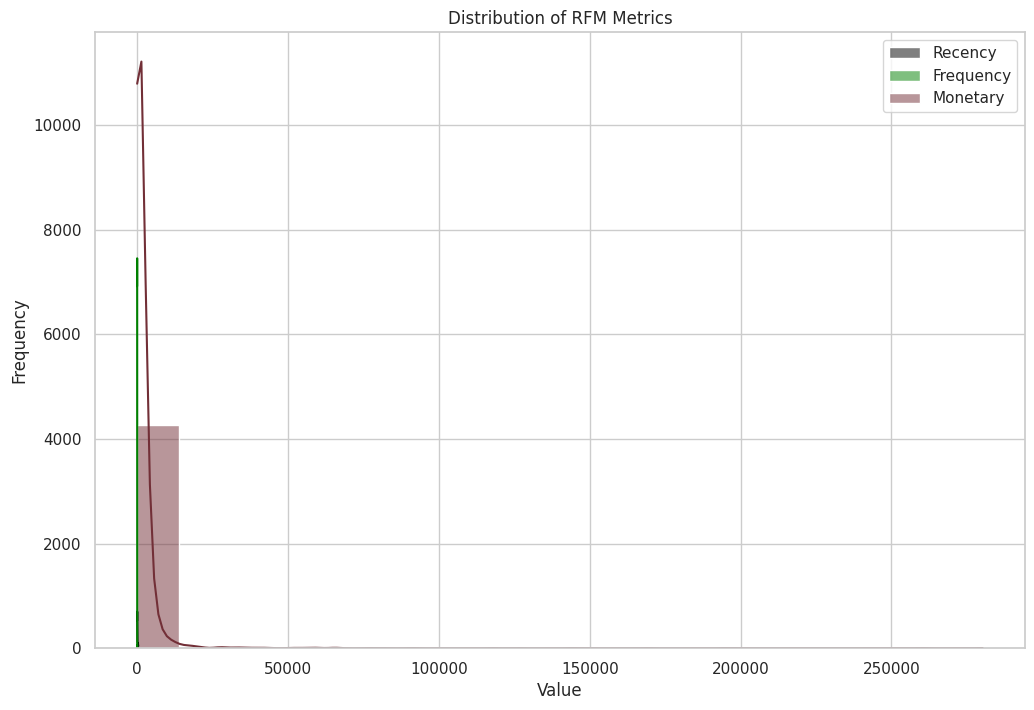

In [143]:
plt.figure(figsize=(12, 8))
sns.histplot(rfm['Recency'], bins=20, kde=True, color='black', label='Recency')
sns.histplot(rfm['Frequency'], bins=20, kde=True, color='green', label='Frequency')
sns.histplot(rfm['Monetary'], bins=20, kde=True, color='#722F37', label='Monetary')
plt.title('Distribution of RFM Metrics')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 6.2 Conteo de Clientes por Segmento

In [169]:
segment_counts = rfm.groupby('Segment').size()
print(segment_counts)

Segment
At Risk               2036
Champions              754
Loyal Customers        115
Others                 945
Potential Loyalist     489
dtype: int64


### 6.3 Gráfico de Dispersión: Frequency vs Monetary

Visualizaremos la relación entre la frecuencia y el gasto, diferenciando por segmento.

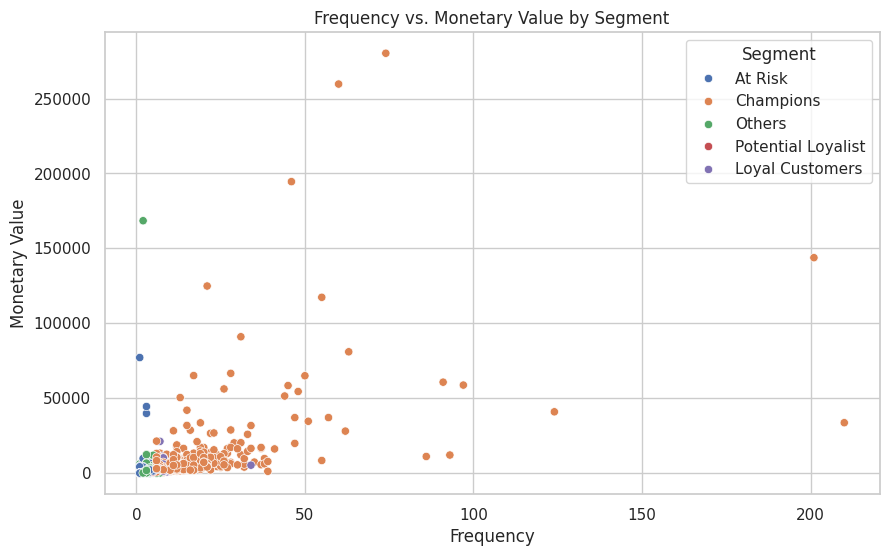

In [170]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Segment', data=rfm)
plt.title('Frequency vs. Monetary Value by Segment')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.show()

## 7. Conclusiones y Próximos Pasos

En este taller hemos:

1. **Preparado y limpiado los datos**: Se simuló un DataFrame, se convirtieron las fechas y se creó la columna `TotalPrice`.
2. **Calculado las métricas RFM** para cada cliente.
3. **Asignado puntajes** a cada métrica utilizando cuartiles.
4. **Definido segmentos** de clientes basados en los puntajes.
5. **Visualizado** la distribución de las métricas y los segmentos.

Utiliza estos resultados para diseñar estrategias de marketing específicas para cada segmento (por ejemplo, campañas de retención para los clientes "At Risk" o programas VIP para los "Champions").

¡Felicidades por completar el taller!